https://github.com/mjpyeon/wavenet-classifier/blob/master/WaveNetClassifier.py

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [2]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\wavenet':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/wavenet/processed.pkl'
    
from src.data import load_data
from src.visualization import multiple_plots, visualize, plot_confusion_matrix
from src.features import make_spectrograms, process_labels, make_directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Activation, Dropout, Add, TimeDistributed, Multiply, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential, load_model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import History, ModelCheckpoint

Using TensorFlow backend.


Import remaining packages

In [0]:
with open(DATA_PATH, "rb") as file:
    data = pickle.load(file)

In [0]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [0]:
train_x = []
train_y = []
test_x = []
test_y = []
test_user = "A"
for user_letter, actions in data.items():
    for action, results in actions.items():
        for result in results:
            for row in result:
                if user_letter == test_user:
                    test_x.append(row)
                    test_y.append(convert_label_to_int(action))
                else:
                    train_x.append(row)
                    train_y.append(convert_label_to_int(action)) 
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)      

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

In [0]:
train_y = np_utils.to_categorical(train_y, nb_classes)
test_y = np_utils.to_categorical(test_y, nb_classes)

In [0]:
train_x = abs(train_x)
test_x = abs(test_x)

In [0]:
# reduce data amount
train_x = train_x[:500,:,:]
train_y = train_y[:500,:]

In [0]:
# need to normalize the data?

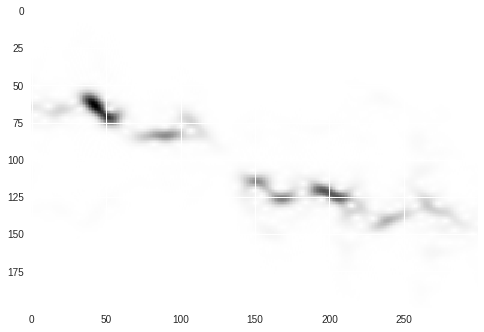

In [11]:
plt.imshow(abs(train_x[5]))

In [0]:
# Standard Parameters
epochs = 50
TRAIN_SAMPLES = train_x.shape[0]
VALID_SAMPLES = test_x.shape[0]
TEST_SAMPLES = test_x.shape[0]

In [0]:
n_filters = 64
dilation_depth = 8
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
batch_size = 4096

In [0]:
def residual_block(x, i):
    tanh_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_tanh' % (kernel_size ** i), 
                      activation='tanh'
                      )(x)
    sigm_out = Conv1D(n_filters, 
                      kernel_size, 
                      dilation_rate = kernel_size**i, 
                      padding='causal', 
                      name='dilated_conv_%d_sigm' % (kernel_size ** i), 
                      activation='sigmoid'
                      )(x)
    z = Multiply(name='gated_activation_%d' % (i))([tanh_out, sigm_out])
    skip = Conv1D(n_filters, 1, name='skip_%d'%(i))(z)
    res = Add(name='residual_block_%d' % (i))([skip, x])
    return res, skip

In [0]:
input_shape = train_x.shape[1:]
output_shape = train_y.shape[1:]

In [0]:
x = Input(shape=input_shape, name='original_input')

In [0]:
skip_connections = []
out = Conv1D(n_filters, 2, dilation_rate=1, padding='causal', name='dilated_conv_1')(x)
for i in range(1, dilation_depth + 1):
    out, skip = residual_block(out,i)
    skip_connections.append(skip)
out = Add(name='skip_connections')(skip_connections)
out = Activation('relu')(out)

In [0]:
out = Conv1D(n_filters, pool_size_1, strides = 1, padding='same', name='conv_5ms', activation = 'relu')(out)
out = AveragePooling1D(pool_size_1, padding='same', name='downsample_to_200Hz')(out)

In [19]:
out = Conv1D(n_filters, pool_size_2, padding='same', activation='relu', name='conv_500ms')(out)
out = Conv1D(output_shape[0], pool_size_2, padding='same', activation='relu', name='conv_500ms_target_shape')(out)
out = AveragePooling1D(pool_size_2, padding='same',name = 'downsample_to_2Hz')(out)
out = Conv1D(output_shape[0], (int) (input_shape[0] / (pool_size_1*pool_size_2)), padding='same', name='final_conv')(out)
out = GlobalAveragePooling1D(name='final_pooling')(out)
out = Activation(activation, name='final_activation')(out)

stroke_read_model = Model(x, out)  
stroke_read_model.compile(optimizer='adam', 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])
stroke_read_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     (None, 200, 300)     0                                            
__________________________________________________________________________________________________
dilated_conv_1 (Conv1D)         (None, 200, 64)      38464       original_input[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_tanh (Conv1D)    (None, 200, 64)      8256        dilated_conv_1[0][0]             
__________________________________________________________________________________________________
dilated_conv_2_sigm (Conv1D)    (None, 200, 64)      8256        dilated_conv_1[0][0]             
__________________________________________________________________________________________________
gated_acti

In [20]:
history = stroke_read_model.fit(train_x, train_y,
                                validation_data = (test_x, test_y), 
                                batch_size = batch_size,
                                epochs = epochs)

Train on 3705 samples, validate on 798 samples
Epoch 1/50
3705/3705 [==============================] - 47s 13ms/step - loss: 1.9620 - acc: 0.1333 - val_loss: 1.9389 - val_acc: 0.1441
Epoch 2/50
3705/3705 [==============================] - 5s 1ms/step - loss: 1.9399 - acc: 0.1549 - val_loss: 1.9295 - val_acc: 0.2494
Epoch 3/50
3705/3705 [==============================] - 5s 1ms/step - loss: 1.9294 - acc: 0.2370 - val_loss: 1.9022 - val_acc: 0.2343
Epoch 4/50
3705/3705 [==============================] - 6s 1ms/step - loss: 1.9007 - acc: 0.2084 - val_loss: 1.8670 - val_acc: 0.1554
Epoch 5/50
3705/3705 [==============================] - 5s 1ms/step - loss: 1.8676 - acc: 0.1611 - val_loss: 1.8195 - val_acc: 0.3020
Epoch 6/50
3705/3705 [==============================] - 5s 1ms/step - loss: 1.8138 - acc: 0.3042 - val_loss: 1.7721 - val_acc: 0.2932
Epoch 7/50
3705/3705 [==============================] - 5s 1ms/step - loss: 1.7629 - acc: 0.2818 - val_loss: 1.6771 - val_acc: 0.4060
Epoch 8/50
37

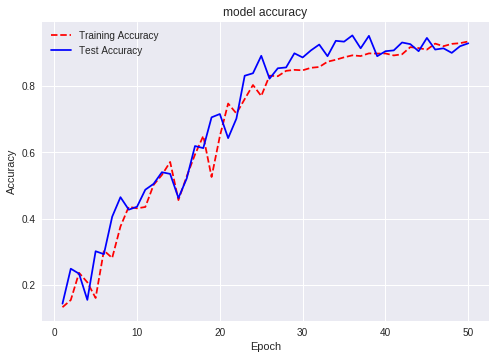

In [21]:
visualize.plot_train_test_acc(history=history)